### Project Title: Heart Attack Treatment Prediction

### Introduction
Heart disease is still one of the main causes of illness and death around the world.  

To improve patient care, it’s important to understand what causes heart disease and how treatments can help reduce its effects.  

This project will study data about heart attack patients, looking at factors like age, lifestyle, and medical history to find useful insights for making better treatment decisions.  

We’ll use machine learning to predict treatment outcomes and identify the most important factors affecting those decisions.  

The dataset includes 1,037 records, each representing a patient who has had a heart attack.  

In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc

from imblearn.over_sampling import SMOTE

### Data Collection

In [2]:
# Data Loading and Initial Exploration

# Load the dataset
data = pd.read_csv('heart_attack_dataset.csv')
data.head()

,Gender,Age,Blood Pressure (mmHg),Cholesterol (mg/dL),Has Diabetes,Smoking Status,Chest Pain Type,Treatment
0,Female,30.0,178.0,178.0,No,Current,Atypical Angina,Medication
1,Female,30.0,159.0,266.0,No,Former,Asymptomatic,Lifestyle Changes
2,Female,30.0,107.0,242.0,Yes,Never,Asymptomatic,Angioplasty
3,Female,31.0,173.0,203.0,No,Current,Atypical Angina,Medication
4,Female,31.0,192.0,283.0,No,Former,Asymptomatic,Lifestyle Changes


### Initial Exploration

In [3]:
# Summary statistics for numerical variables
numerical_summary = data.describe()
numerical_summary

,Age,Blood Pressure (mmHg),Cholesterol (mg/dL)
count,1016.000000,1031.000000,1031.000000
mean,60.330709,145.199806,223.754607
std,17.312340,31.629512,42.891157
min,30.000000,90.000000,150.000000
25%,45.000000,118.000000,185.000000
50%,60.500000,145.000000,226.000000
75%,76.000000,172.000000,259.000000
max,89.000000,199.000000,299.000000


In [4]:
# Initial Exploration
print(data.shape)
print(data.info())


(1037, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037 entries, 0 to 1036
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Gender                 1037 non-null   object 
 1   Age                    1016 non-null   float64
 2   Blood Pressure (mmHg)  1031 non-null   float64
 3   Cholesterol (mg/dL)    1031 non-null   float64
 4   Has Diabetes           1030 non-null   object 
 5   Smoking Status         1027 non-null   object 
 6   Chest Pain Type        1031 non-null   object 
 7   Treatment              1035 non-null   object 
dtypes: float64(3), object(5)
memory usage: 64.9+ KB
None


In [5]:
# Check total null values in each column
print(data.isnull().sum())

Gender                    0
Age                      21
Blood Pressure (mmHg)     6
Cholesterol (mg/dL)       6
Has Diabetes              7
Smoking Status           10
Chest Pain Type           6
Treatment                 2
dtype: int64


### Data Cleaning

In [6]:
# Count missing values in 'age' column for each gender
missing_values_by_gender = data.groupby('Gender')['Age'].apply(lambda x: x.isnull().sum())

print(missing_values_by_gender)

Gender
Female     9
Male      12
Name: Age, dtype: int64


In [7]:
# This is block of code to fill missing values in the 'numerical' columns with the average value of each column

# Calculate average age for each gender (male and female)
average_age_by_gender = data.groupby('Gender')['Age'].mean()

# Fill missing values in the age column
data['Age'] = data.apply(
    lambda row: average_age_by_gender[row['Gender']] if np.isnan(row['Age']) else row['Age'], axis=1
)

# Calculate the average of the "Blood Pressure" column, ignoring NaN values
average_bp = data['Blood Pressure (mmHg)'].mean()

# Fill missing values with the average
data['Blood Pressure (mmHg)'].fillna(average_bp, inplace=True)

# Calculate the average of the "Cholesterol" column, ignoring NaN values
average_bp = data['Cholesterol (mg/dL)'].mean()

# Fill missing values with the average
data['Cholesterol (mg/dL)'].fillna(average_bp, inplace=True)

C:\Users\5A_Traders\AppData\Local\Temp\ipykernel_20760\1639838678.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Blood Pressure (mmHg)'].fillna(average_bp, inplace=True)
C:\Users\5A_Traders\AppData\Local\Temp\ipykernel_20760\1639838678.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [8]:
# This is block of code to fill missing values in the 'Categorical' columns 
# with the most frequent (mode) value of each column

# Calculate the most frequent value (mode) of the "Has Diabetes" column
most_frequent_value = data['Has Diabetes'].mode()[0]
data['Has Diabetes'].fillna(most_frequent_value, inplace=True)

# Fill missing values in 'Smoking Status' column with the most frequent value
most_frequent_value = data['Smoking Status'].mode()[0]
data['Smoking Status'].fillna(most_frequent_value, inplace=True)


# Calculate the most frequent value (mode) of the "Chest Pain Type " column
most_frequent_value = data['Chest Pain Type'].mode()[0]
data['Chest Pain Type'].fillna(most_frequent_value, inplace=True)

# Drop rows where the "Treatment" column has missing values
df = data.dropna(subset=['Treatment'], inplace=True)

data.isnull().sum() 


C:\Users\5A_Traders\AppData\Local\Temp\ipykernel_20760\1644629933.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Has Diabetes'].fillna(most_frequent_value, inplace=True)
C:\Users\5A_Traders\AppData\Local\Temp\ipykernel_20760\1644629933.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

Gender                   0
Age                      0
Blood Pressure (mmHg)    0
Cholesterol (mg/dL)      0
Has Diabetes             0
Smoking Status           0
Chest Pain Type          0
Treatment                0
dtype: int64

In [9]:
# Afetr cleaning check, No. of male and female in the dataset
print(data.shape)

# Count the occurrences of each gender
gender_counts = data['Gender'].value_counts()

# Print the counts
print("Number of males:", gender_counts.get('Male', 0))
print("Number of females:", gender_counts.get('Female', 0))


(1035, 8)
Number of males: 529
Number of females: 506


### Exploratory Data Analysis (EDA)

In [10]:
# Distribution of Numerical variables
categorical_distribution = {
    column: data[column].value_counts() for column in data.select_dtypes(include=['object']).columns
}

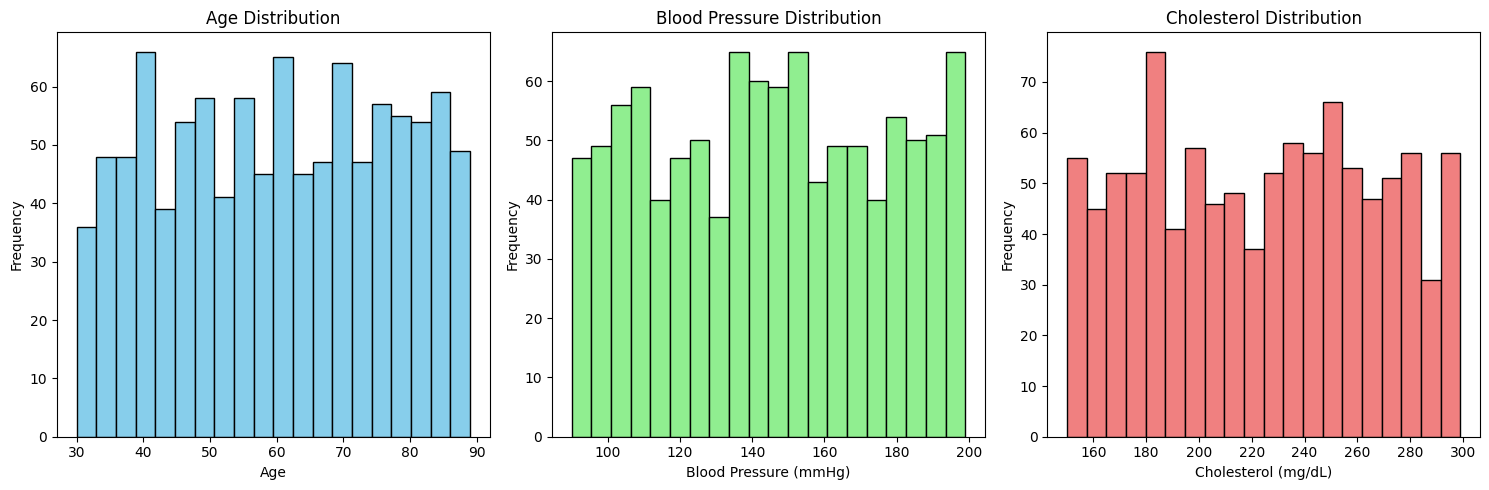

In [11]:
# Histograms for numerical variables
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(data['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(data['Blood Pressure (mmHg)'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Blood Pressure Distribution')
plt.xlabel('Blood Pressure (mmHg)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(data['Cholesterol (mg/dL)'], bins=20, color='lightcoral', edgecolor='black')
plt.title('Cholesterol Distribution')
plt.xlabel('Cholesterol (mg/dL)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Age:  
Most patients are older, with an average age of around 60. The wide age range shows that the dataset includes people of different age groups, which is important because age is a major risk factor for heart disease.  

Blood Pressure:  
The average blood pressure is 145.2 mmHg, which is above the normal range of 120/80 mmHg. This suggests that many patients likely have hypertension (130–139/80–89 mmHg), a common risk factor for heart attacks.  

Cholesterol:  
Cholesterol levels are generally high, with an average of about 224 mg/dL, and many patients have levels over 240 mg/dL. High cholesterol is another key risk factor for heart attacks.  

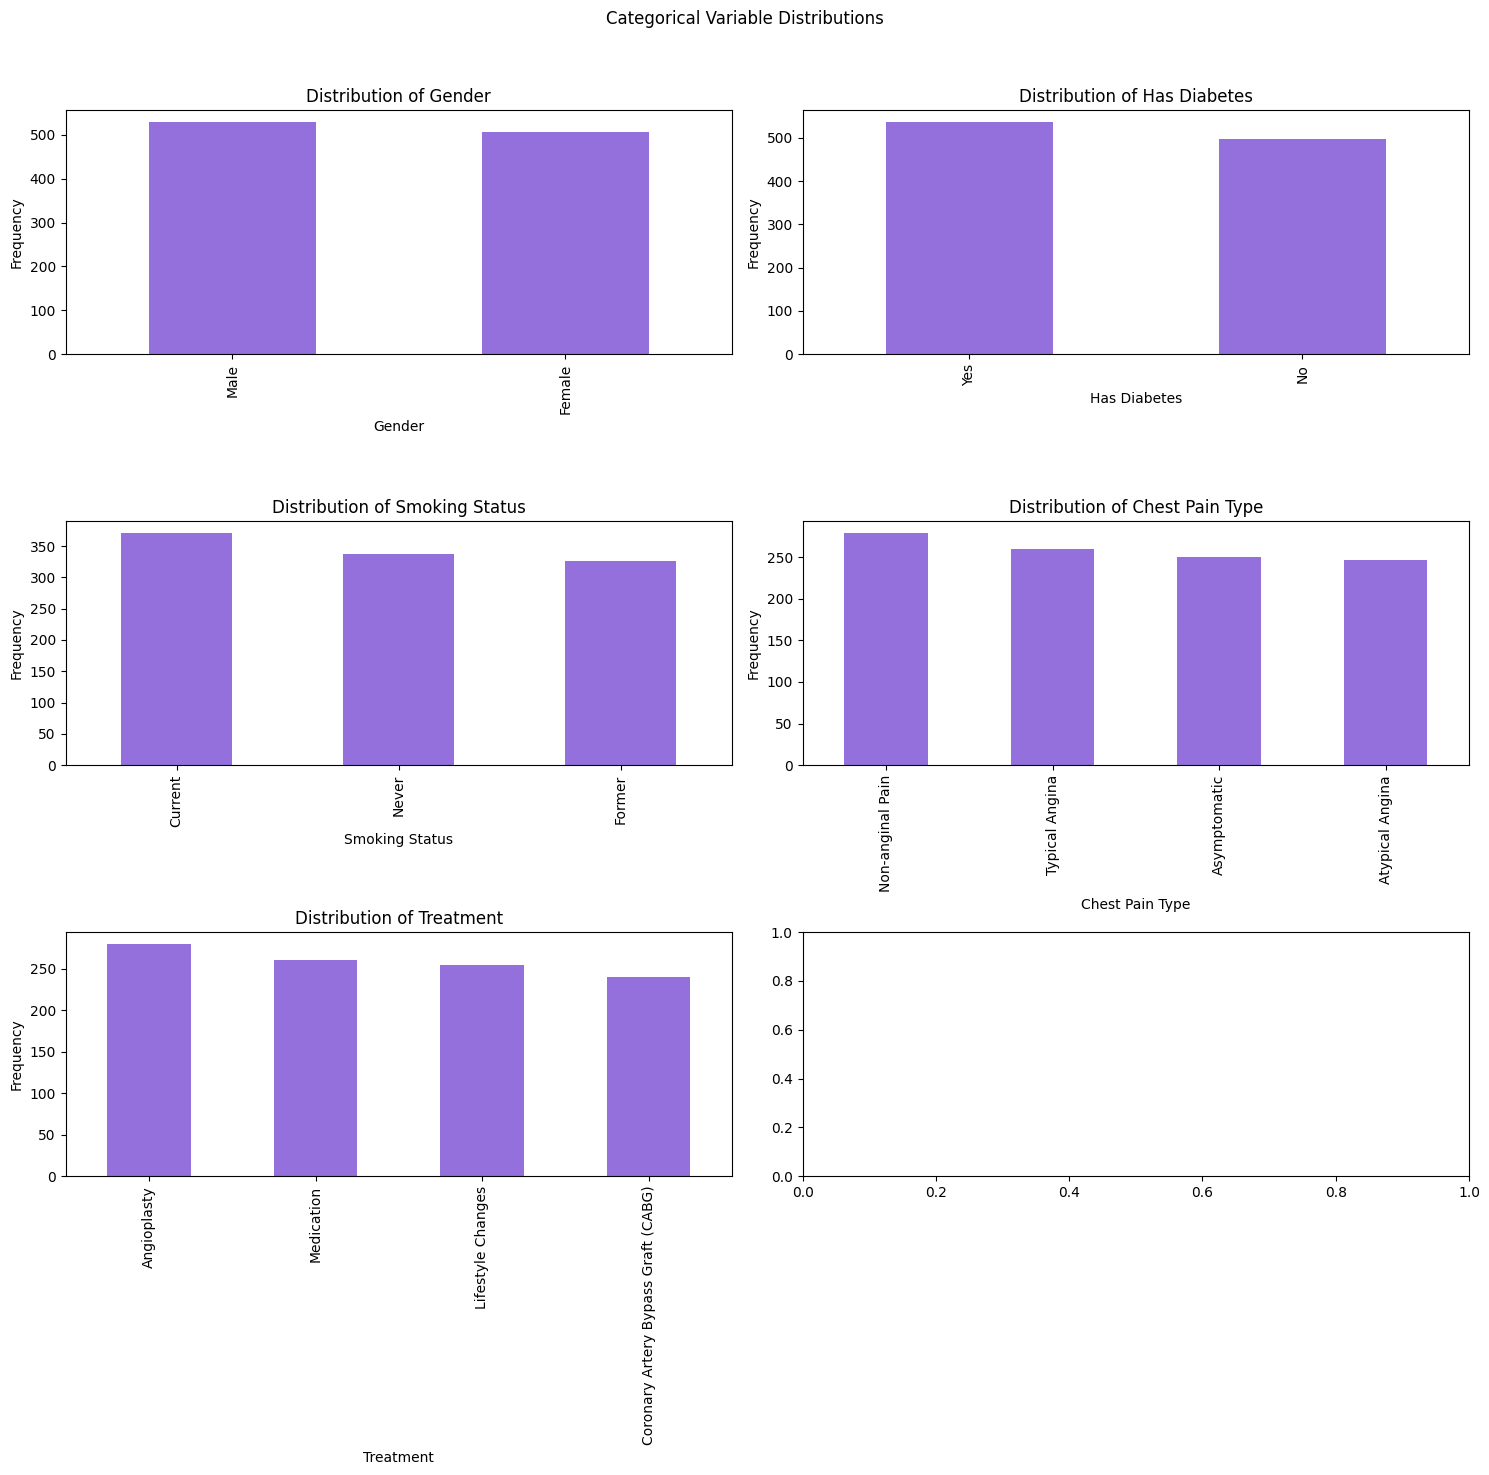

In [12]:
# Categorical variables Distribution
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Categorical Variable Distributions')

for ax, (column, values) in zip(axes.flatten(), categorical_distribution.items()):
    values.plot(kind='bar', ax=ax, color='mediumpurple')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The data shows an almost equal split between male (529) and female (506) patients, making it possible to compare treatment and outcomes based on gender.  

A little over half of the patients have diabetes (537), highlighting a strong link between diabetes and heart disease in this group.  

Smoking status is fairly balanced, with most patients having never smoked (338). However, the presence of current (371) and former smokers (326) emphasizes smoking as a significant risk factor for heart disease.  

The chest pain types vary among patients, showing a mix of clinical symptoms. This suggests that chest pain type could be a key factor in understanding and predicting treatment outcomes. (Non-anginal Pain: 279, Asymptomatic: 250, Typical Angina: 260, Atypical Angina: 246).  

Treatment types are evenly distributed, indicating a balanced approach to care. This balance makes the data well-suited for predictive modeling without bias toward any specific treatment. (Lifestyle Changes: 254, CABG: 240, Angioplasty: 280, Medication: 261).  

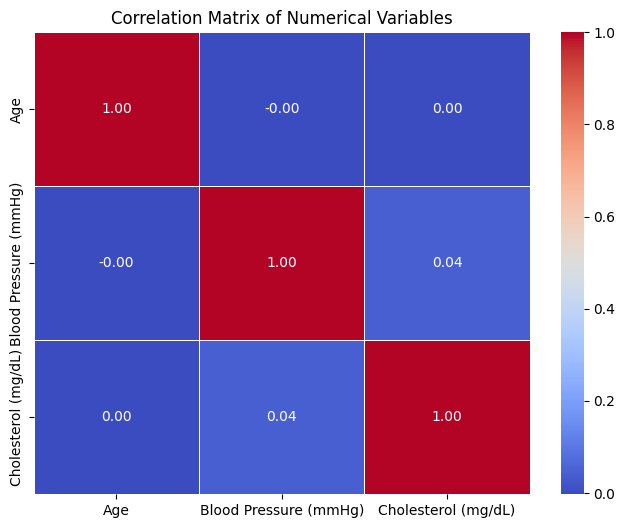

In [13]:
# Correlation Analysis of Numerical Variables
correlation_matrix = data[['Age', 'Blood Pressure (mmHg)', 'Cholesterol (mg/dL)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

#### Correlation Insights:

Age:  
There is no significant correlation between age and blood pressure or cholesterol levels.  

Blood Pressure (mmHg):  
There is a very weak positive correlation with cholesterol (0.044), which is nearly negligible.  

Cholesterol (mg/dL):  
There is no notable correlation with either age or blood pressure.  

Overall, these weak correlations suggest that age, blood pressure, and cholesterol are mostly independent of each other in this dataset.  

Key Takeaways:  
Since these numerical variables don’t strongly predict one another, it may be more useful to explore relationships between categorical variables and outcomes, such as treatment choices.  

Next Steps:  
To uncover potential significant associations, I will perform a Chi-Square Test for independence, focusing on:  
- **Smoking Status and Treatment**  
- **Diabetes Status and Treatment**  
- **Gender and Treatment**  

This analysis will help identify whether these variables are meaningfully linked to treatment decisions.  

In [14]:
# Chi-Square Test (examine the relationships between categorical variables)
from scipy.stats import chi2_contingency

contingency_tables = {
    'Smoking Status vs Treatment': pd.crosstab(data['Smoking Status'], data['Treatment']),
    'Has Diabetes vs Treatment': pd.crosstab(data['Has Diabetes'], data['Treatment']),
    'Gender vs Treatment': pd.crosstab(data['Gender'], data['Treatment']),
}

chi_square_results = {}
for test_name, table in contingency_tables.items():
    chi2, p, dof, expected = chi2_contingency(table)
    chi_square_results[test_name] = {'Chi2 Statistic': chi2, 'p-value': p, 'Degrees of Freedom': dof, 'Expected Frequencies': expected}
    chi_square_results_df = pd.DataFrame(chi_square_results)

chi_square_results_df 


,Smoking Status vs Treatment,Has Diabetes vs Treatment,Gender vs Treatment
Chi2 Statistic,1.512011,1.038861,2.15497
p-value,0.958693,0.79185,0.540872
Degrees of Freedom,6,3,3
Expected Frequencies,"[[100.3671497584541, 86.02898550724638, 91.047...","[[134.7246376811594, 115.47826086956522, 122.2...","[[136.88888888888889, 117.33333333333333, 124...."


### Chi-Square tests were conducted to examine the relationships between categorical variables and treatment types. Below are the results:



| Metric                  | Smoking Status vs Treatment| Has Diabetes vs Treatment | Gender vs Treatment |
|-------------------------|----------------------------|---------------------------|-------------------- |
| Chi2 Statistic          | 1.512011                   | 1.038861                 | 2.15497              |
| p-value                 | 0.958693                   | 0.79185                  | 0.540872             |
| Degrees of Freedom      | 6                          | 3                        | 3                    |


As observed, none of the categorical variables (Smoking Status, Diabetes Status, Gender) show a statistically significant link to the treatment type.  

This indicates that treatment decisions in the dataset are likely influenced by other factors, or these variables are evenly distributed across different treatments.  

Next, we’ll move on to predictive modeling using machine learning to identify which treatment could be recommended based on the variables in the dataset.


### Feature Engineering

In [15]:
# Feature Encoding and Scaling Block 

# Map categorical variables to numerical values
categorical_columns = ['Gender', 'Has Diabetes', 'Smoking Status', 'Chest Pain Type', 'Treatment']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Prepare features and target variable
X = data_encoded.drop(columns=[col for col in data_encoded.columns if 'Treatment_' in col])
y = pd.Categorical(data['Treatment']).codes

# Standardize numerical features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [16]:
# Handling Imbalance and Splitting Data

# Handle class imbalance using SMOTE with adjusted k_neighbors
smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


### Modelling

In [17]:
# Model Training and Hyperparameter Tuning

# Hyperparameter tuning for Random Forest
grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), grid_params, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_rf = grid_search.best_estimator_


In [18]:
# Model Evaluation

# Predictions and evaluation
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=np.unique(y_resampled)), y_prob, average='macro', multi_class='ovr')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"ROC-AUC Score: {roc_auc}")


Accuracy: 0.34375
ROC-AUC Score: 0.5792104421307507


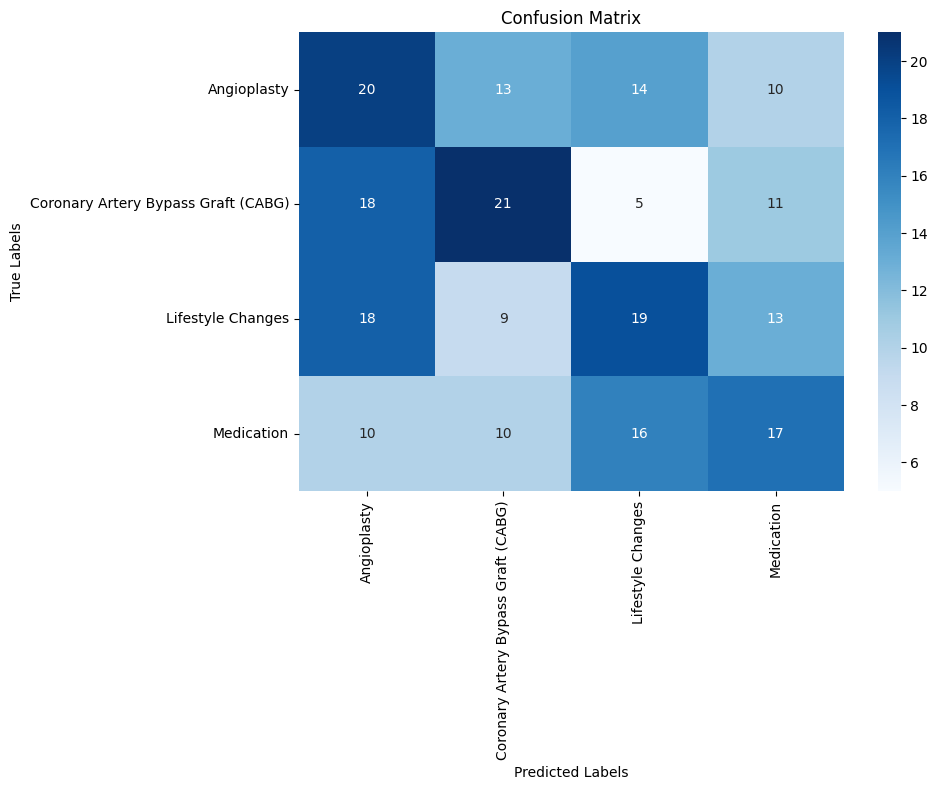

In [19]:
# Confusion matrix

label_encoder = LabelEncoder()
class_labels = label_encoder.fit(data['Treatment']).classes_

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()

# Display the plot
plt.show()

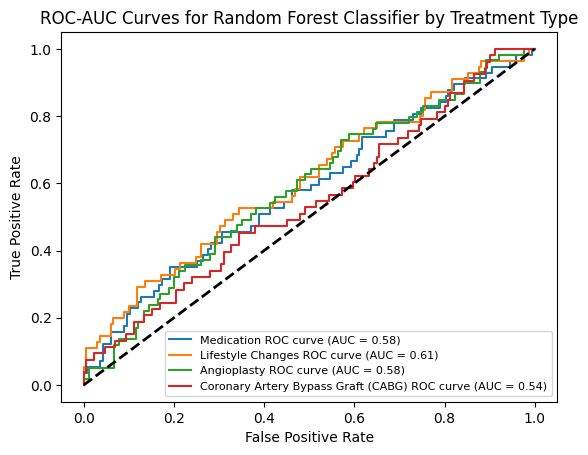

In [20]:
# ROC Curve Plotting

# Mapping class indices to treatment labels
class_labels = ['Medication', 'Lifestyle Changes', 'Angioplasty', 'Coronary Artery Bypass Graft (CABG)']

fpr = {}
tpr = {}
roc_auc = {}

for i, class_label in enumerate(class_labels):
    # Compute ROC curve
    fpr[class_label], tpr[class_label], _ = roc_curve(
        label_binarize(y_test, classes=np.arange(len(class_labels)))[:, i],
        y_prob[:, i]
    )
    # Compute AUC
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])
    # Plot each ROC curve with the treatment label and AUC
    plt.plot(fpr[class_label], tpr[class_label], label=f'{class_label} ROC curve (AUC = {roc_auc[class_label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curves for Random Forest Classifier by Treatment Type')
plt.legend(loc="lower right", fontsize="8")
plt.show()


The low accuracy and ROC-AUC score show that the Random Forest model is not performing well in predicting treatment types.  

This could mean that the available features are not strong predictors for treatment decisions, or that the model might need to account for more complex interactions between the variables.  

### Communication (Summary)

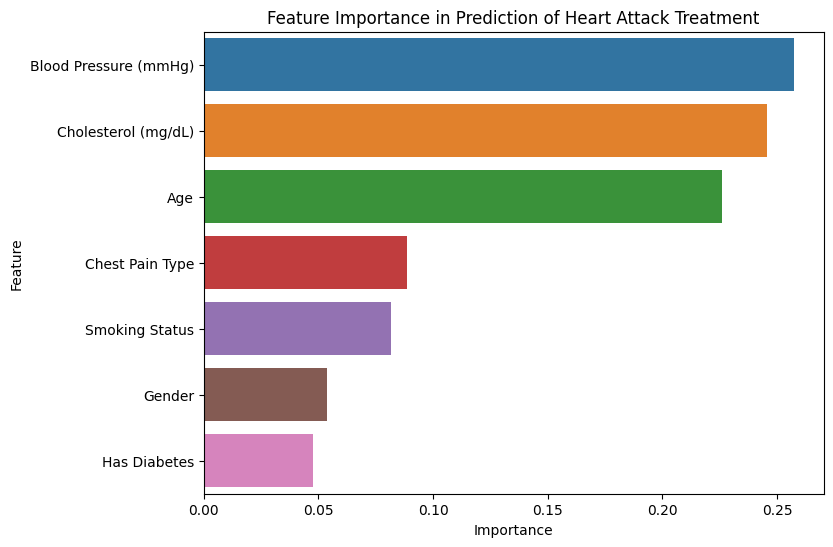

In [21]:
# Extract feature names and their corresponding importance scores

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': best_rf.feature_importances_})

# Group importance by main categories
main_categories = {
    'Age': 'Age',
    'Blood Pressure (mmHg)': 'Blood Pressure (mmHg)',
    'Cholesterol (mg/dL)': 'Cholesterol (mg/dL)',
    'Gender_Male': 'Gender',
    'Gender_Female': 'Gender',
    'Has Diabetes_Yes': 'Has Diabetes',
    'Has Diabetes_No': 'Has Diabetes',
    'Smoking Status_Never': 'Smoking Status',
    'Smoking Status_Current': 'Smoking Status',
    'Smoking Status_Former': 'Smoking Status',
    'Chest Pain Type_Non-anginal Pain': 'Chest Pain Type',
    'Chest Pain Type_Asymptomatic': 'Chest Pain Type',
    'Chest Pain Type_Typical Angina': 'Chest Pain Type',
    'Chest Pain Type_Atypical Angina': 'Chest Pain Type'
}

# Map the main categories to the features
feature_importances['Main Category'] = feature_importances['Feature'].map(main_categories)

# Aggregate importance by main category
aggregated_importances = feature_importances.groupby('Main Category')['Importance'].sum().reset_index()

# Sort by importance
aggregated_importances = aggregated_importances.sort_values(by='Importance', ascending=False)

# Plot the aggregated feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Main Category', data=aggregated_importances)
plt.title('Feature Importance in Prediction of Heart Attack Treatment')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


The feature importance from the Random Forest model highlights the contribution of each variable to predicting the treatment type:  

### Top Features:  
- **Blood Pressure (mmHg):** 25.03%  
- **Cholesterol (mg/dL):** 24.96%  
- **Age:** 24.80%  

These three numerical variables are the most influential, collectively contributing about 74% to the model's predictions.  

### Less Important Features:  
- **Chest Pain Type:** 7.95%  
- **Smoking Status:** 7.68%  
- **Has Diabetes:** 4.80%  
- **Gender:** 4.74%  

The categorical variables have a smaller impact, which aligns with the earlier Chi-Square test results.  

### Key Insight:  
The prominence of numerical variables like blood pressure, cholesterol, and age suggests that these health metrics play a bigger role in determining treatment decisions compared to lifestyle factors such as smoking status or diabetes presence.  